# PA004 - HEALTH INSURANCE CROS-SELL

## 0 - IMPORTS AND FUNCTIONS

In [1]:
import warnings
import optuna
import random
import pickle

import lightgbm              as lgbm
import scikitplot            as skplt
import matplotlib.patches    as mpatches
import matplotlib.pyplot     as plt
import numpy                 as np
import plotly.express        as px
import pandas                as pd
import seaborn               as sns

from IPython.core.display    import HTML
from IPython.display         import Image
from xgboost                 import XGBClassifier
from sklearn.metrics         import log_loss
from sklearn.model_selection import StratifiedKFold
from optuna.integration      import LightGBMPruningCallback
from imblearn.over_sampling  import RandomOverSampler
from sklearn.metrics import confusion_matrix, accuracy_score,precision_score, roc_auc_score,classification_report,roc_curve,auc

from sklearn                 import preprocessing             as pp
from sklearn                 import model_selection           as ms
from sklearn                 import neighbors                 as nh
from sklearn                 import ensemble                  as en


warnings.filterwarnings( 'ignore' )

/home/reng/.pyenv/versions/3.9.15/envs/health_insurance_venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 0.1 - HELPER FUNCTIONS

In [2]:
def recall_at_k (data, k=20000):
    # Reset Index
    data = data.reset_index( drop=True )

    # Create Ranking Order
    data['ranking'] = data.index + 1

    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    return data.loc[k, 'recall_at_k'] 

def precision_at_k (data, k=20000):
    # Reset Index
    data = data.reset_index( drop=True )

    # Create Ranking Order
    data['ranking'] = data.index + 1

    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    return data.loc[k, 'precision_at_k']

def cramer_v( x, y):
    cm = pd.crosstab( x, y).values   
    n = cm.sum()
    r, k = cm.shape    
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1) 
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def prediction_score(model, data):
    # Separating train and validation dataset for each kfold
    x_train = data.drop(columns=['response'])
    y_train = data['response']
    
    # prediction probability (score)
    yhat_proba = model.predict_proba(x_train)[:, 1].tolist()
    
    # merging score to dataset
    data_scored = data.copy()
    data_scored['score'] = yhat_proba
    
    # sort
    data_scored = data_scored.sort_values('score', ascending=False)
    
    # precision and recall
    data_scored = data_scored.reset_index(drop=True)
    data_scored['n_samples'] = data_scored.index + 1
    data_scored['precision_at_k'] = data_scored['response'].cumsum() / data_scored['n_samples']
    data_scored['recall_at_k'] = data_scored['response'].cumsum() / data_scored['response'].sum()
    
    return data_scored

def cross_validation(kfold, modelName, model, data, at_k):
    # Number of folds
    fold=ms.StratifiedKFold(n_splits = kfold, shuffle=True, random_state=42)
    
    # Performance variables
    precision_list = []
    recall_list = []
    cv_performance = {}
    
    for train_cv,val_cv in fold.split(data, data['response']):
        
        # Separating train and validation dataset for each kfold
        # training data
        x_train_fold = data.iloc[train_cv]
        x_train_fold = x_train_fold[cols_selected]
        
        y_train_fold = data['response'].iloc[train_cv]
        
        # validation data
        x_val_fold = data.iloc[val_cv]
        x_val_fold = x_val_fold[cols_selected]
        
        y_val_fold = data['response'].iloc[val_cv]
        
        # fitting the model
        model_fitted = model.fit(x_train_fold,y_train_fold)
        
        # getting the prediction probability
        x_val_fold['response'] = y_val_fold
        val_scored = prediction_score(model_fitted, x_val_fold)
        
        # Getting precision and recall at k
        precision = val_scored.loc[at_k, 'precision_at_k']
        recall = val_scored.loc[at_k, 'recall_at_k']
        
        precision_list.append(precision)
        recall_list.append(recall)
        
    # calculating the mean and std performance of all kfolds
    precision_cv = np.round(np.mean(precision_list),4).astype(float)
    std_precision_cv = '+/-' + np.round(np.std(precision_list),4).astype(str)
    recall_cv = np.round(np.mean(recall_list),4).astype(float)
    std_recall_cv = ' +/- ' + np.round(np.std(recall_list),4).astype(str)
        
    cv_performance[modelName] = [precision_cv, std_precision_cv, recall_cv, std_recall_cv]
    model_performance_cv = pd.DataFrame(cv_performance, index=['precision_at_k', 'std_precision', 'recall_at_k', 'std_recall'])

    return model_performance_cv

def ml_performance( model_name, precision_atK, recall_atK ):
    
    return pd.DataFrame( {'Model Name': model_name,
                          'Precision_at_K': precision_atK,
                          'Recall_at_K': recall_atK}, index=[0])

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [18, 8]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container {width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [3]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 1 - DATAS

In [4]:
# Train Datas - Windows
df = pd.read_csv('/home/reng/Documents/ds_repos/Projects/Health_Insurance_Cross_Sell/data/raw/data.csv')

### 1.1 - SPLIT DATASET INTO TRAINING, TEST AND VALIDATION

In [5]:
# Creation of test dataset

X = df.drop( 'response', axis=1 )
y = df['response'].copy()

xbase, x_base, ytest, y_test = ms.train_test_split( X, y, test_size=0.10 )

base = pd.concat([ xbase, ytest ], axis=1 )
test_ans = pd.concat([ x_base, y_test ], axis=1 )

print(f" xbase: {xbase.shape}\n ytest: {ytest.shape}\n x_base: {x_base.shape}\n y_test: {y_test.shape}\n")

 xbase: (342998, 11)
 ytest: (342998,)
 x_base: (38111, 11)
 y_test: (38111,)



In [6]:
# Save test dataset locally
x_base.to_csv('/home/reng/Documents/ds_repos/Projects/Health_Insurance_Cross_Sell/data/raw/test_sample.csv')

In [7]:
# Creation of training and validation dataset

X = base.drop( 'response', axis=1 )
y = base['response'].copy()

x_training, x_valid, y_training, y_valid = ms.train_test_split( X, y, test_size=0.20 )

df1 = pd.concat([x_training, y_training], axis=1)
df1_valid = pd.concat([x_valid, y_valid], axis=1)

print(f" x_training: {x_training.shape}\n y_training: {y_training.shape}\n x_valid: {x_valid.shape}\n y_valid: {y_valid.shape}\n df1: {df1.shape}\n df1_valid: {df1_valid.shape}")

 x_training: (274398, 11)
 y_training: (274398,)
 x_valid: (68600, 11)
 y_valid: (68600,)
 df1: (274398, 12)
 df1_valid: (68600, 12)


### 1.2 - DATA DESCRIPTION

In [8]:
# Data Dimensions
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Numfer of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 274398
Numfer of Cols: 12


In [9]:
# Data Types
df1.dtypes

id                       int64
gender                  object
age                      int64
region_code              int64
policy_sales_channel     int64
driving_license          int64
vehicle_age             object
vehicle_damage          object
previously_insured       int64
annual_premium           int64
vintage                  int64
response                 int64
dtype: object

In [10]:
# Changing data types
df1['region_code'] = df1['region_code'].astype(object)
df1['policy_sales_channel'] = df1['policy_sales_channel'].astype(object)

In [11]:
# Check NAN Values
df1.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

### 1.3 - DATA DESCRIPTIVE

In [12]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 274398 entries, 92605 to 317994
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   id                    274398 non-null  int64 
 1   gender                274398 non-null  object
 2   age                   274398 non-null  int64 
 3   region_code           274398 non-null  object
 4   policy_sales_channel  274398 non-null  object
 5   driving_license       274398 non-null  int64 
 6   vehicle_age           274398 non-null  object
 7   vehicle_damage        274398 non-null  object
 8   previously_insured    274398 non-null  int64 
 9   annual_premium        274398 non-null  int64 
 10  vintage               274398 non-null  int64 
 11  response              274398 non-null  int64 
dtypes: int64(7), object(5)
memory usage: 27.2+ MB


In [13]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
id,274398.0,190743.397896,110013.597877,4.0,95469.50,190943.5,286017.75,381109.0
age,274398.0,38.814182,15.499216,20.0,25.00,36.0,49.00,85.0
driving_license,274398.0,0.997905,0.045729,0.0,1.00,1.0,1.00,1.0
previously_insured,274398.0,0.457336,0.498177,0.0,0.00,0.0,1.00,1.0
annual_premium,274398.0,30578.744823,17244.181306,2630.0,24407.25,31675.0,39421.00,540165.0
vintage,274398.0,154.339518,83.692953,10.0,82.00,154.0,227.00,299.0
response,274398.0,0.123303,0.328785,0.0,0.00,0.0,0.00,1.0


In [14]:
# Select columns where the content is different 0 or 1.
num_attributes = df1[['age','annual_premium','vintage']]
cat_attributes = df1[['driving_license','region_code','policy_sales_channel','previously_insured','gender','vehicle_age','vehicle_damage']]
target_atribute = df1['response']

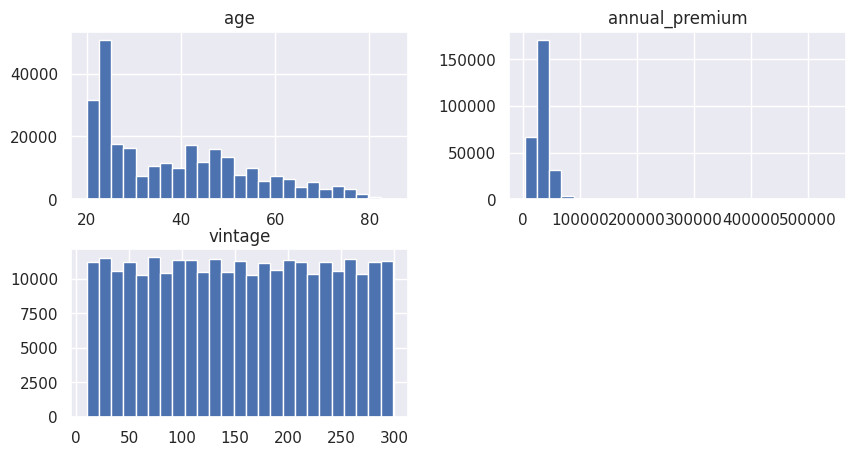

In [15]:
num_attributes.hist(bins=25, figsize = (10, 5 ));

In [16]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concatenar
m = pd.concat( [ d2, d3, d4, ct1, ct2, d1, d5, d6 ] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,20.0,85.0,65.0,38.814182,36.0,15.499188,0.672610,-0.564675
1,annual_premium,2630.0,540165.0,537535.0,30578.744823,31675.0,17244.149884,1.890361,37.481702
2,vintage,10.0,299.0,289.0,154.339518,154.0,83.692801,0.002936,-1.200847


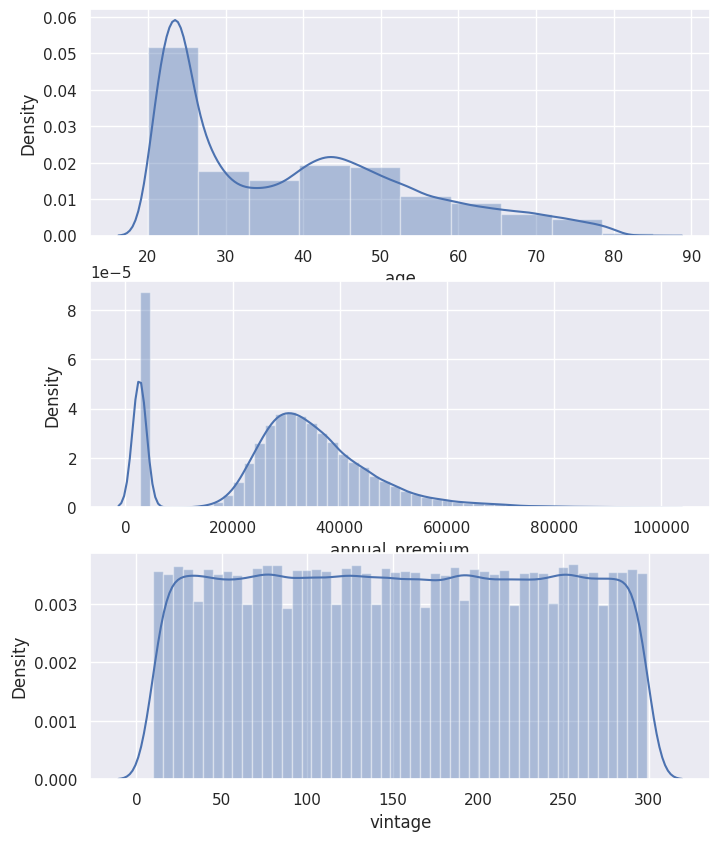

In [17]:
# Looking at the distribuition of the following variables.
fig, axs = plt.subplots(3, figsize = (8, 10))
sns.distplot(df1['age'], ax=axs[0], bins=10)
sns.distplot(df1[df1['annual_premium']<100000]['annual_premium'], ax=axs[1])
sns.distplot(df1['vintage'], ax=axs[2]);

<AxesSubplot: xlabel='vehicle_damage', ylabel='count'>

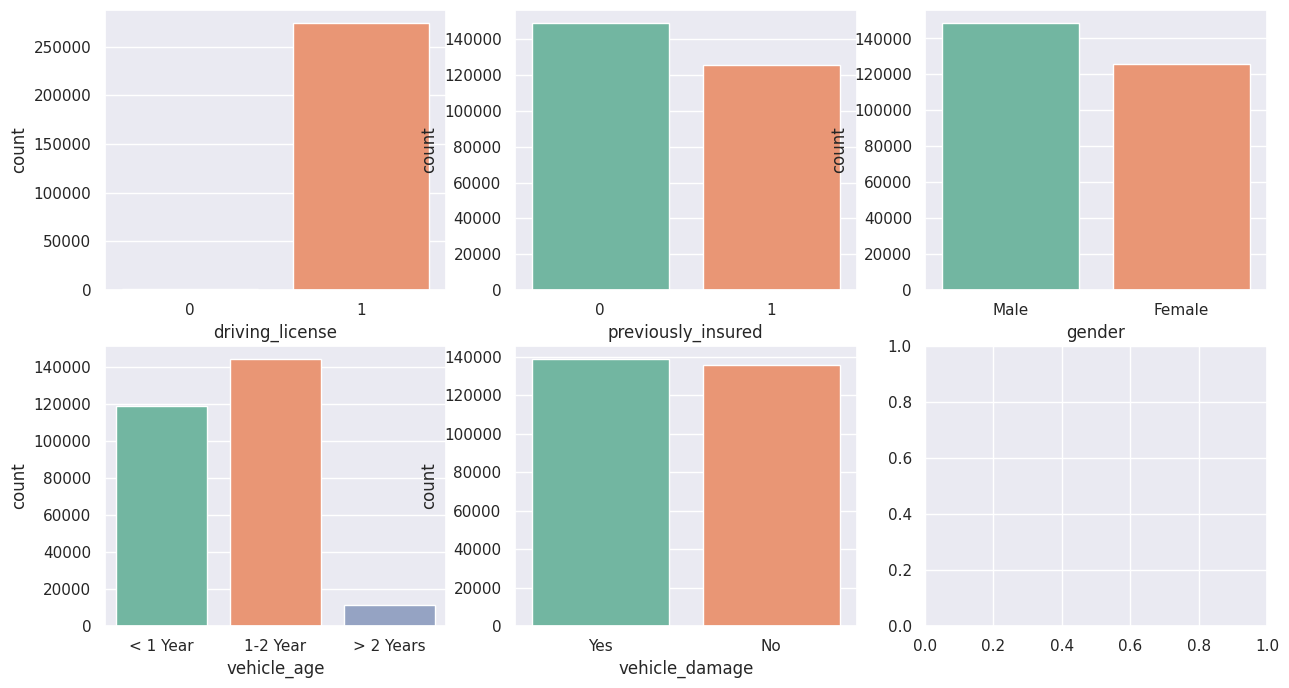

In [18]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize= (15, 8))

sns.countplot(x = 'driving_license', palette = 'Set2', data=df1, ax=axs[0][0])
sns.countplot(x = 'previously_insured', palette = 'Set2', data=df1, ax=axs[0][1])
sns.countplot(x = 'gender', palette = 'Set2', data=df1, ax=axs[0][2])
sns.countplot(x = 'vehicle_age', palette = 'Set2', data=df1, ax=axs[1][0])
sns.countplot(x = 'vehicle_damage', palette = 'Set2', data=df1, ax=axs[1][1])

<AxesSubplot: xlabel='region_code', ylabel='count'>

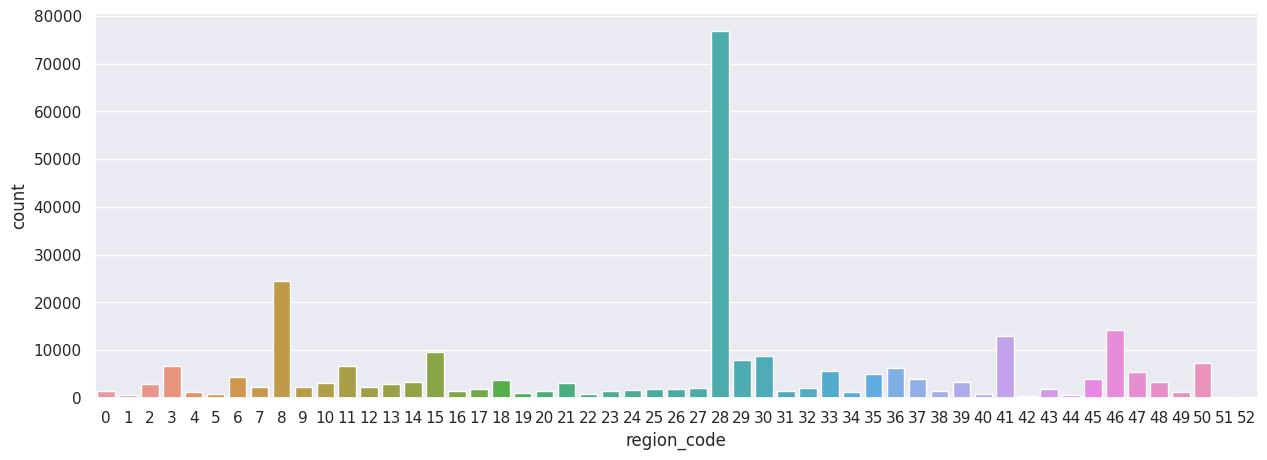

In [19]:
fig = plt.subplots(figsize = (15,5))
sns.countplot(x='region_code', data=df1)

<AxesSubplot: xlabel='policy_sales_channel', ylabel='index'>

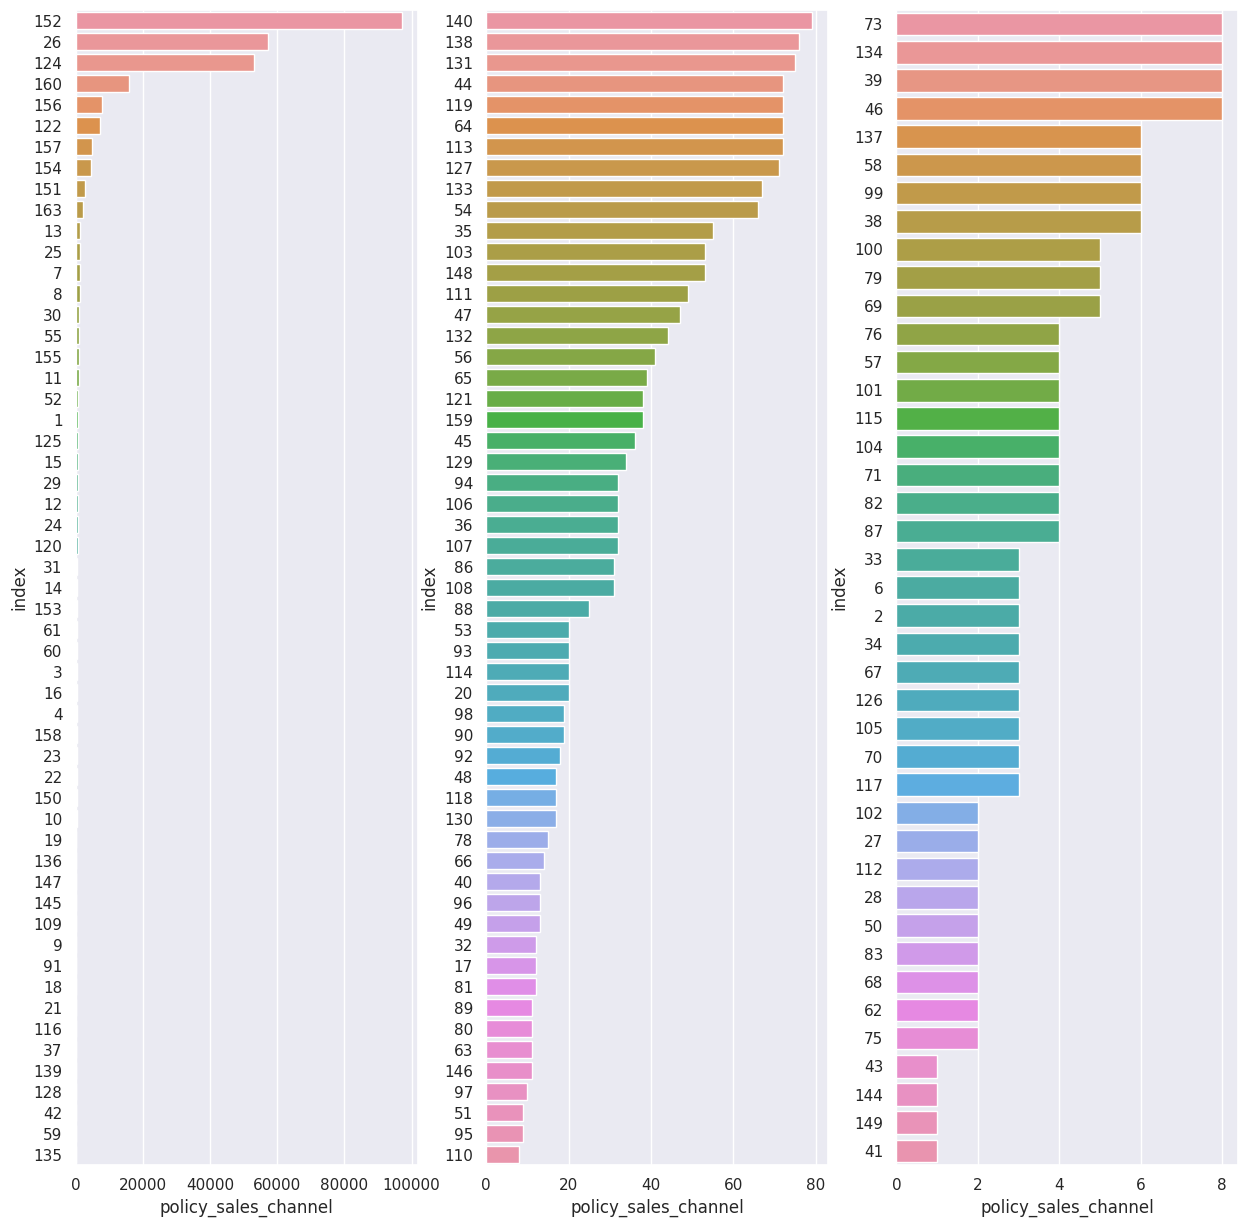

In [20]:
policy_1 = df1['policy_sales_channel'].value_counts().iloc[0:55]
policy_1 = policy_1.reset_index()
policy_2 = df1['policy_sales_channel'].value_counts().iloc[55:110]
policy_2 = policy_2.reset_index()
policy_3 = df1['policy_sales_channel'].value_counts().iloc[110:156]
policy_3 = policy_3.reset_index()

fig, axs = plt.subplots(ncols=3, figsize=(15,15))
sns.barplot(y='index', x='policy_sales_channel', data=policy_1, ax=axs[0], orient='h', order=policy_1['index'])
sns.barplot(y='index', x='policy_sales_channel', data=policy_2, ax=axs[1], orient='h', order=policy_2['index'])
sns.barplot(y='index', x='policy_sales_channel', data=policy_3, ax=axs[2], orient='h', order=policy_3['index'])

## 2 - FEATURE ENGINEERING

In [21]:
df2 = df1.copy()

In [22]:
# Fitting vehicle_age column
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 1 if (x == '< 1 Year') else 2 if (x == '1-2 Year') else 3)

# Fitting vehicle_damage column
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if (x == 'Yes') else 0)

In [ ]:
df2.dtypes

### 2.1 - NEW FEATURES

In [23]:
# median_premium_by_region
dict_region_code = df2[['annual_premium', 'region_code']].groupby('region_code').median().to_dict(orient='dict')['annual_premium']
df2['median_premium_by_region'] = df2['region_code'].map(dict_region_code)

# moda policy sales chanel por idade
mode_policy_per_age = df2[['age', 'policy_sales_channel']].groupby('age').agg(pd.Series.mode).to_dict(orient='dict')['policy_sales_channel']
df2['mode_policy_per_age'] = df2['age'].map(mode_policy_per_age)

# Media de carros danificados por idade
avg_carros_danificados_idade = df2[['age', 'vehicle_damage']].groupby('age').mean().to_dict(orient='dict')['vehicle_damage']
df2['avg_vehicle_damage_per_age'] = df2['age'].map(avg_carros_danificados_idade)

# Media de carros danificados por regiao
avg_carros_danificados_regiao = df2[['region_code', 'vehicle_damage']].groupby('region_code').mean().to_dict(orient='dict')['vehicle_damage']
df2['avg_vehicle_damage_region_code'] = df2['region_code'].map(avg_carros_danificados_regiao)

# age_group feature creation
df2['age_group'] = df2['age'].apply(lambda x: 1 if (x >= 18 | x < 30 ) else 2 if (x >= 30 | x < 60 ) else 3)

# vintage_month feature cration
df2['vintage_month'] = round(df2['vintage'] / 31)

# day_premium feature creation
df2['day_premium'] = df2['annual_premium']/df2['vintage']

# age_premium feature cration
df2['age_premium'] = df2['annual_premium']/df2['age']

# Calculating Median Annual Premium by Region_code
premium_rc = df2[['annual_premium', 'region_code']].groupby('region_code').median().to_dict(orient='dict')['annual_premium']
df2['region_premium'] = df2['region_code'].map(premium_rc)

# Calculating Median Aday_premium per policy_sales_channel
day_premium_psc = df2[['day_premium', 'policy_sales_channel']].groupby('policy_sales_channel').mean().to_dict(orient='dict')['day_premium']
df2['avg_day_premium_policy'] = df2['policy_sales_channel'].map(day_premium_psc)

# avg vintage per age
avg_vintage_per_age = df2[['age', 'vintage']].groupby('age').mean().to_dict(orient='dict')['vintage']
df2['avg_vintage_age'] = df2['age'].map(avg_vintage_per_age)

## 3 - DATA FILTERING

In [24]:
df3 = df2.copy()

## 4 - EXPLORATORY DATA ANALYSIS (EDA)

In [25]:
df4 = df3.copy()

### 4.1 - UNIVARIATE ANALYSIS

In [ ]:
df4.head()

In [ ]:
plt.figure(figsize = (20, 25))
plt.suptitle("Analysis Of Variable Response",fontweight="bold", fontsize=20)

plt.subplot(6,2,1)
sns.countplot(x = 'response', hue = 'gender', palette = 'Set2', data = df4)

plt.subplot(6,2,2)
sns.countplot(x = 'response', hue = 'previously_insured', palette = 'Set2', data = df4)

plt.subplot(6,2,3)
sns.countplot(x = 'response', hue = 'vehicle_age', palette = 'Set2', data = df4)

plt.subplot(6,2,4)
sns.countplot(x = 'response', hue = 'vehicle_damage', palette = 'Set2', data = df4)

plt.subplot(6,2,5)
sns.countplot(x = 'response', hue = 'driving_license', palette = 'Set2', data = df4)

plt.subplot(6,2,6)
sns.countplot(x='response', hue = 'age_group', palette = 'Set2', data=df4)

plt.subplot(6,2,7)
sns.kdeplot(x='age', hue='response', palette = 'Set2', shade=True, data=df4)

plt.subplot(6,2,8)
sns.kdeplot(x='annual_premium', hue='response', palette = 'Set2', shade=True, data=df4)

plt.subplot(6,2,9)
sns.kdeplot(x='day_premium', hue='response', palette = 'Set2', shade=True, data=df4)

plt.subplot(6,2,10)
sns.kdeplot(x='age_premium', hue='response', palette = 'Set2', shade=True, data=df4)

plt.subplot(6,2,11)
sns.kdeplot(x='vintage', hue='response', palette = 'Set2', shade=True, data=df4)

In [ ]:
# 'policy_sales_channel'

# set the figure size
plt.figure(figsize=(25, 10))

# from raw value to percentage
total = df4.groupby('policy_sales_channel')['id'].count().reset_index()
response_1 = df4.loc[df4.response == 1 ].groupby('policy_sales_channel')['id'].count().reset_index()
response_0 = df4.loc[df4.response == 0 ].groupby('policy_sales_channel')['response'].sum().reset_index()
resp = pd.merge(response_1, response_0, how = 'outer', on = 'policy_sales_channel')
resp['id'] = resp['id'].fillna(0)
resp = resp.sort_values(by='policy_sales_channel')
resp['id'] = [i / j * 100 for i,j in zip(resp['id'], total['id'])]
total['id'] = [i / j * 100 for i,j in zip(total['id'], total['id'])]

# bar chart 1 -> top bars (group of 'smoker=No')
bar1 = sns.barplot(x="policy_sales_channel",  y="id", data=total, color='darkblue')

# bar chart 2 -> bottom bars (group of 'smoker=Yes')
bar2 = sns.barplot(x="policy_sales_channel", y="id", data=resp, color='lightblue')

# add legend
plt.xticks(rotation=90)
top_bar = mpatches.Patch(color='darkblue', label='response = No')
bottom_bar = mpatches.Patch(color='lightblue', label='response = Yes')
plt.legend(handles=[top_bar, bottom_bar])

# show the graph
plt.show()

### 4.2 - BIVARIATE ANALYSIS

In [ ]:
#1.The interest on purchase the vehicle insurance is greater for customers that damaged their vehicle before and doesn't have insurance. (FALSE)
d1 = df2[( df2['previously_insured'] == 0) & (df2['vehicle_damage'] == 1)]

ax1 = d1[['response','id']].groupby('response').count().reset_index()
ax1['percentage'] = round(ax1['id'] / d1['id'].count()*100)
ax1

In [ ]:
# 2. The interest on purchase the vehicle insurance is greater for woman than men. (FALSE)
aux2 = pd.crosstab(df2['gender'], df2['response'])
aux2['percentage'] = aux2[1]/(aux2[0]+aux2[1])
aux2

In [ ]:
# 3. The interest on purchase vehicle insurance is greater for vintage customers( 7 months or more )
aux3 = df2[df2['vintage_month'] >= 7 ][['id','response']]
aux4 = df2[df2['vintage_month'] < 7 ][['id','response']]

fix, axs = plt.subplots(ncols = 2, figsize = (15,4))
sns.countplot(x = aux3['response'], ax=axs[0]).set_title('Vintage Customer: 7 months or more')
sns.countplot(x = aux4['response'], ax=axs[1]).set_title('Vintage Customer: 7 months or less')

In [ ]:
aux18 = aux3[['response','id']].groupby('response').count().reset_index()
aux18['percentage'] = round( aux18['id'] / aux3.shape[0] * 100 )
aux18

In [ ]:
aux19 = aux4[['response','id']].groupby('response').count().reset_index()
aux19['percentage'] = round( aux19['id'] / aux4.shape[0] * 100 )
aux19

In [ ]:
# 4. The interest on purchase the vehicle insurance is greater for customers that spend less than 30k for annual premium.
aux5 = df2[df2['annual_premium'] > 30000][['id','response']]
aux6 = df2[df2['annual_premium'] <= 30000][['id','response']]

fix, axs = plt.subplots(ncols = 2, figsize = (15,4))
sns.countplot(x = aux5['response'], ax=axs[0]).set_title('Annual Premium: 30k or more')
sns.countplot(x = aux6['response'], ax=axs[1]).set_title('Annual Premium: 30k or less')

In [ ]:
aux16 = aux5[['response','id']].groupby('response').count().reset_index()
aux16['percentage'] = round( aux16['id'] / aux5.shape[0] * 100 )
aux16

In [ ]:
aux17 = aux6[['response','id']].groupby('response').count().reset_index()
aux17['percentage'] = round( aux17['id'] / aux6.shape[0] * 100 )
aux17

In [ ]:
# 5. The interest on purchase the vehicle insurance is greater for young customers.(Between 18 and 30 years old.)
ax7 = sns.countplot(x = df2['response'], hue=df2['age_group'])

In [ ]:
aux8 = pd.crosstab(df2['age_group'], df2['response'])
aux8['percentage'] = aux8[1]/(aux8[0]+aux8[1])
aux8

In [ ]:
# 6. The interest on purchase the vehicle insurance is greater for customers that have driver license.
aux9 = pd.crosstab(df2['driving_license'], df2['response'])
aux9['percentage'] = round(aux9[1]/(aux9[0]+aux9[1])*100)
aux9

In [ ]:
# 7. The interest on purchase the vehicle insurance is greater for customers that have new cars.
aux10 = pd.crosstab(df2['vehicle_age'], df2['response'])
aux10['percentage'] = round(aux10[1]/(aux10[0]+aux10[1])*100)
aux10

In [ ]:
# 8. The interest on purchase the vehicle insurance is greater for customers that have new cars and have damaged their vehicles.
aux11 = df2[(df2['vehicle_damage'] == 1 )]
aux12 = pd.crosstab(aux11['vehicle_age'], aux11['response'])
aux12['percentage'] = round(aux12[1]/(aux12[0]+aux12[1])*100)
aux12

In [ ]:
# 9. The interest on purchase the vehicle insurance is greater for elderly women.
aux13 = df2[(df2['gender'] == 'Female')]
aux14 = pd.crosstab(aux13['age_group'], aux13['response'])
aux14['percentage'] = round(aux14[1]/(aux14[0]+aux14[1])*100)
aux14

In [ ]:
# 10. The interest on purchase the vehicle insurance is lower for customers that are already insured.
aux15 = pd.crosstab(df2['previously_insured'], df2['response'])
aux15['percentage'] = round(aux15[1]/(aux15[0]+aux15[1])*100)
aux15

**Hypothesis Validation**

1. The interest on purchase the vehicle insurance is greater for customers that damaged their vehicle before and doesn't have insurance.
    **False, of the customers that damaged their car and doesn't have insurance, only 25% show interest in acquire vehicle insurance.**

2. The interest on purchase the vehicle insurance is greater for woman than men.
    **False, only 10% of women show interest in acquire vehicle insurance, whereas 13% of the men show interest on acquire vehicle insurance.**

3. The interest on purchase vehicle insurance is greater for vintage customers ( 7 months or more ).
    **False, the period that customers are on the company doensn't show influency on interest in buying vehicle insurance.**

4. The interest on purchase the vehicle insurance is greater for young customers.(Between 18 and 30 years old.)
    **False, customers that spend more than 30k yearly show greter interest on purchase vehicle insurance.**

5. The interest on purchase the vehicle insurance is greater for young customers.(Between 18 and 30 years old.)
    **False, adults and elderlies show greater interest on buying vehicle insurance.**

6. The interest on purchase the vehicle insurance is greater for customers that have driver license.
    **True, arround 12% of customers that hold a driving license show interest in buying the vehicle insurance.**

7. The interest on purchase the vehicle insurance is greater for customers that have new cars.
    **False, the interest is greater for customers that own an old car.**

8. The interest on purchase the vehicle insurance is greater for customers that have new cars and have damaged their vehicles.
    **False, of the customers who damaged their car, the ones that own a old car show greater interest in buying the vehicle insurance (29%), followed by customers that own used cars (27%).**

9. The interest on purchase the vehicle insurance is greater for elderly women.
    **False, adult women show greater interest in buying the vehicle insurance.**

10. The interest on purchase the vehicle insurance is lower for customers that are already insured.
    **True, less than 1% of customers already insured show interest on purchase the vehicle insurance.**


### 4.3 - MULTIVARIATE ANALYSIS

In [ ]:
correlation = df2.corr().round(2)
plt.figure(figsize = (14,7))
sns.heatmap(correlation, annot = True)

## 5 - DATA PREPARATION

In [26]:
df5 = df4.copy()

In [27]:
df5.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response,median_premium_by_region,mode_policy_per_age,avg_vehicle_damage_per_age,avg_vehicle_damage_region_code,age_group,vintage_month,day_premium,age_premium,region_premium,avg_day_premium_policy,avg_vintage_age
92605,358054,Male,26,14,152,1,1,1,0,28713,175,0,26954.0,152,0.213634,0.352854,1,6.0,164.074286,1104.346154,26954.0,366.000722,153.919355
131574,289859,Female,25,47,152,1,1,0,1,45264,117,0,31977.5,152,0.231803,0.516292,3,4.0,386.871795,1810.560000,31977.5,366.000722,154.542911
34096,272314,Male,49,38,124,1,2,1,0,2630,117,0,27852.0,26,0.680757,0.636107,3,4.0,22.478632,53.673469,27852.0,378.581569,153.743428
283098,356624,Female,26,41,152,1,1,0,1,27161,46,0,31625.0,152,0.213634,0.415818,1,1.0,590.456522,1044.653846,31625.0,366.000722,153.919355
136246,326853,Male,40,45,152,1,2,0,1,30123,64,0,27065.5,124,0.680262,0.470270,3,2.0,470.671875,753.075000,27065.5,366.000722,153.987110


### 5.1 - Balancing Dataset

In [ ]:
df6[['id','response']].groupby('response').count().reset_index()

In [ ]:
non_interested=df6[df6['response'] == 1]
interested=df6[df6['response'] == 0][:37304]
df=pd.concat([non_interested,interested])
df7 = df.sample(frac=1,random_state=42)
df7.shape

In [ ]:
df7[['id','response']].groupby('response').count().reset_index()

In [ ]:
x_training = df7.drop( 'response', axis=1 )
y_training = df7['response'].copy()

In [ ]:
df8 = df7.copy()

### 5.2 - STANDARDIZATION

In [28]:
##### Subtrai-se a media e divide-se pelo desvio padrao
ss_ap = pp.StandardScaler()
ss_ag = pp.StandardScaler()
ss_dp = pp.StandardScaler()
ss_dpp = pp.StandardScaler()
ss_mp = pp.StandardScaler()
ss_rp = pp.StandardScaler()

# annual premium
df5['annual_premium'] = ss_ap.fit_transform( df5[['annual_premium']].values )
#pickle.dump(ss_ap, open('C:/Users/perot/Documents/ds_repos/projects/Health_Insurance_Cross_Sell/src/features/annual_premium_scaler.pkl', 'wb'))

# age_premium
df5['age_premium'] = ss_ag.fit_transform( df5[['age_premium']].values )
#pickle.dump(ss_ag, open('C:/Users/perot/Documents/ds_repos/projects/Health_Insurance_Cross_Sell/src/features/age_premium_scaler.pkl', 'wb'))

# day_premium
df5['day_premium'] = ss_dp.fit_transform( df5[['day_premium']].values )
#pickle.dump(ss_dp, open('C:/Users/perot/Documents/ds_repos/projects/Health_Insurance_Cross_Sell/src/features/day_premium_scaler.pkl', 'wb'))

# avg_day_premium_policy
df5['avg_day_premium_policy'] = ss_dpp.fit_transform( df5[['avg_day_premium_policy']].values )
#pickle.dump(ss_dpp, open('C:/Users/perot/Documents/ds_repos/projects/Health_Insurance_Cross_Sell/src/features/avg_day_premium_policy_scaler.pkl', 'wb'))

# median_premium_by_region
df5['median_premium_by_region'] = ss_mp.fit_transform( df5[['median_premium_by_region']].values )
#pickle.dump(ss_mp, open('C:/Users/perot/Documents/ds_repos/projects/Health_Insurance_Cross_Sell/src/features/median_premium_by_region_scaler.pkl', 'wb'))

# region_premium
df5['region_premium'] = ss_rp.fit_transform( df5[['region_premium']].values )
#pickle.dump(ss_rp, open('C:/Users/perot/Documents/ds_repos/projects/Health_Insurance_Cross_Sell/src/features/region_premium_scaler.pkl', 'wb'))

### 5.3 - REESCALING

In [29]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()
mms_vintage_age = pp.MinMaxScaler()
mms_vm = pp.MinMaxScaler()
mms_vd_rc = pp.MinMaxScaler()

# Age
df5['age'] = mms_age.fit_transform( df5[['age']].values )
#pickle.dump(mms_age, open('C:/Users/perot/Documents/ds_repos/projects/Health_Insurance_Cross_Sell/src/features/age_scaler.pkl', 'wb'))

# Vintage
df5['vintage'] = mms_vintage.fit_transform( df5[['vintage']].values )
#pickle.dump(mms_vintage, open('C:/Users/perot/Documents/ds_repos/projects/Health_Insurance_Cross_Sell/src/features/vintage_scaler.pkl', 'wb'))

# avg_vintage_age
df5['avg_vintage_age'] = mms_vintage_age.fit_transform( df5[['avg_vintage_age']].values )
#pickle.dump(mms_vintage_age, open('C:/Users/perot/Documents/ds_repos/projects/Health_Insurance_Cross_Sell/src/features/avg_vintage_age_scaler.pkl', 'wb'))

# vintage_month
df5['vintage_month'] = mms_vm.fit_transform( df5[['vintage_month']].values )
#pickle.dump(mms_vintage, open('C:/Users/perot/Documents/ds_repos/projects/Health_Insurance_Cross_Sell/src/features/vintage_scaler.pkl', 'wb'))

# avg_vehicle_damage_region_code
df5['avg_vehicle_damage_region_code'] = mms_vd_rc.fit_transform( df5[['avg_vehicle_damage_region_code']].values )
#pickle.dump(mms_vd_rc, open('C:/Users/perot/Documents/ds_repos/projects/Health_Insurance_Cross_Sell/src/features/avg_vehicle_damage_region_code_scaler.pkl', 'wb'))

### 5.4 - ENCODER

In [30]:
# gender
target_encode_gender = df5.groupby( 'gender' )['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map( target_encode_gender )
#pickle.dump(target_encode_gender, open('C:/Users/perot/Documents/ds_repos/projects/Health_Insurance_Cross_Sell/src/features/target_encode_gender_scaler.pkl', 'wb'))

# region_code - Frequency Encoding / Target Encoding / Weighted Targed Encoding
fe_region_code = df5.groupby( 'region_code').size() / len( df5 )
df5.loc[:, 'region_code'] = df5['region_code'].map( fe_region_code )
#pickle.dump(fe_region_code, open('C:/Users/perot/Documents/ds_repos/projects/Health_Insurance_Cross_Sell/src/features/frequency_encode_region_code_scaler.pkl', 'wb'))

# policy_sales_channel - Frequency Encoding / Target Encoding
fe_policy_sales_channel = df5.groupby( 'policy_sales_channel' ).size() / len( df5 ) 
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( fe_policy_sales_channel )
#pickle.dump(fe_policy_sales_channel, open('C:/Users/perot/Documents/ds_repos/projects/Health_Insurance_Cross_Sell/src/features/frequency_encode_policy_sales_scaler.pkl', 'wb'))

# vintage_month
target_encode_vintage_month = df5.groupby( 'vintage_month' )['response'].mean()
df5.loc[:, 'vintage_month'] = df5['vintage_month'].map( target_encode_vintage_month )
#pickle.dump(target_encode_vintage_month, open('C:/Users/perot/Documents/ds_repos/projects/Health_Insurance_Cross_Sell/src/features/target_encode_vintage_month_scaler.pkl', 'wb'))

### 5.5 - VALIDATION PREPARATION

#### Apply Feature Engineering on validation dataset ( df1_valid )

In [31]:
# Fitting vehicle_age column
df1_valid['vehicle_age'] = df1_valid['vehicle_age'].apply(lambda x: 1 if (x == '< 1 Year') else 2 if (x == '1-2 Year') else 3)

# Fitting vehicle_damage column
df1_valid['vehicle_damage'] = df1_valid['vehicle_damage'].apply(lambda x: 1 if (x == 'Yes') else 0)

# median_premium_by_region
dict_region_code = df1_valid[['annual_premium', 'region_code']].groupby('region_code').median().to_dict(orient='dict')['annual_premium']
df1_valid['median_premium_by_region'] = df1_valid['region_code'].map(dict_region_code)

# moda policy sales chanel por idade
mode_policy_per_age = df1_valid[['age', 'policy_sales_channel']].groupby('age').agg(pd.Series.mode).to_dict(orient='dict')['policy_sales_channel']
df1_valid['mode_policy_per_age'] = df1_valid['age'].map(mode_policy_per_age)

# Media de carros danificados por idade
avg_carros_danificados_idade = df1_valid[['age', 'vehicle_damage']].groupby('age').mean().to_dict(orient='dict')['vehicle_damage']
df1_valid['avg_vehicle_damage_per_age'] = df1_valid['age'].map(avg_carros_danificados_idade)

# Media de carros danificados por regiao
avg_carros_danificados_regiao = df1_valid[['region_code', 'vehicle_damage']].groupby('region_code').mean().to_dict(orient='dict')['vehicle_damage']
df1_valid['avg_vehicle_damage_region_code'] = df1_valid['region_code'].map(avg_carros_danificados_regiao)

# age_group feature creation
df1_valid['age_group'] = df1_valid['age'].apply(lambda x: 1 if (x >= 18 | x < 30 ) else 2 if (x >= 30 | x < 60 ) else 3)

# vintage_month feature cration
df1_valid['vintage_month'] = round(df1_valid['vintage'] / 31)

# day_premium feature creation
df1_valid['day_premium'] = df1_valid['annual_premium']/df1_valid['vintage']

# age_premium feature cration
df1_valid['age_premium'] = df1_valid['annual_premium']/df1_valid['age']

# Calculating Median Annual Premium by Region_code
premium_rc = df1_valid[['annual_premium', 'region_code']].groupby('region_code').median().to_dict(orient='dict')['annual_premium']
df1_valid['region_premium'] = df1_valid['region_code'].map(premium_rc)

# Calculating Median Aday_premium per policy_sales_channel
day_premium_psc = df1_valid[['day_premium', 'policy_sales_channel']].groupby('policy_sales_channel').mean().to_dict(orient='dict')['day_premium']
df1_valid['avg_day_premium_policy'] = df1_valid['policy_sales_channel'].map(day_premium_psc)

# avg vintage per age
avg_vintage_per_age = df1_valid[['age', 'vintage']].groupby('age').mean().to_dict(orient='dict')['vintage']
df1_valid['avg_vintage_age'] = df1_valid['age'].map(avg_vintage_per_age)

#### Split df1_valid into validation dataset

In [32]:
x_valid = df1_valid.drop('response', axis=1)
y_valid = df1_valid['response'].copy()

In [33]:
# STANDARDIZATION

# annual premium
x_valid.loc[:, 'annual_premium'] = ss_ap.transform( x_valid[['annual_premium']].values )

# age_premium
x_valid.loc[:, 'age_premium'] = ss_ag.transform( x_valid[['age_premium']].values )

# day_premium
x_valid.loc[:, 'day_premium'] = ss_dp.transform( x_valid[['day_premium']].values )

# avg_day_premium_policy
x_valid.loc[:,'avg_day_premium_policy'] = ss_dpp.fit_transform( x_valid[['avg_day_premium_policy']].values )

# median_premium_by_region
x_valid.loc[:,'median_premium_by_region'] = ss_mp.fit_transform( x_valid[['median_premium_by_region']].values )

# region_premium
x_valid.loc[:,'region_premium'] = ss_rp.fit_transform( x_valid[['region_premium']].values )



# REESCALING

# age
x_valid.loc[:, 'age'] = mms_age.transform( x_valid[['age']].values )

# vintage
x_valid.loc[:, 'vintage'] = mms_vintage.transform( x_valid[['vintage']].values )

# avg_vintage_age
x_valid.loc[:,'avg_vintage_age'] = mms_vintage_age.fit_transform( x_valid[['avg_vintage_age']].values )

# vintage_month
x_valid.loc[:,'vintage_month'] = mms_vm.fit_transform( x_valid[['vintage_month']].values )

# avg_vehicle_damage_region_code
x_valid.loc[:,'avg_vehicle_damage_region_code'] = mms_vd_rc.fit_transform( x_valid[['avg_vehicle_damage_region_code']].values )



# ENCODER

# policy sales channel
x_valid.loc[:, 'policy_sales_channel'] = x_valid['policy_sales_channel'].map( fe_policy_sales_channel )

# region code
x_valid.loc[:, 'region_code'] = x_valid.loc[:, 'region_code'].map( fe_region_code )

# gender
x_valid.loc[:, 'gender'] = x_valid.loc[:, 'gender'].map( target_encode_gender )

# vintage_month
x_valid.loc[:, 'vintage_month'] = x_valid['vintage_month'].map( target_encode_vintage_month )

# FILL NAN VALUES
x_valid = x_valid.fillna(0)

## 6 - FEATURE SELECTION

In [46]:
x_training = df5.drop('response', axis=1 )
y_training = df5['response'].copy()

In [47]:
# model definition
forest = en.ExtraTreesClassifier( n_estimators =250, random_state=0, n_jobs=-1 )

# data preparation
x_train_n = df5.drop( ['id', 'response'], axis=1 )
y_train_n  = y_training.values
forest.fit( x_train_n, y_train_n )

ValueError: setting an array element with a sequence.

In [ ]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0 )
indices = np.argsort(importances)[::-1]

# Print the feature ranking 
print("Feature ranking:")
df = pd.DataFrame()
for i,j in zip( x_train_n, forest.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df = pd.concat( [df,aux], axis = 0 )
    
print( df.sort_values( 'importance', ascending=False ) )

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train_n.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

## 7 - FEATURE ENGINEERING

### 7.1 - MACHINE LEARNING MODEL TRAINING

#### 7.1.1 - UNBALANCED DATASET

In [48]:
cols_selected = ['day_premium','vintage','age_premium','annual_premium','vehicle_damage','vintage_month','previously_insured','policy_sales_channel','region_code','region_premium','median_premium_by_region',
                 'avg_day_premium_policy','age','avg_vehicle_damage_per_age','vehicle_age','avg_vehicle_damage_region_code','gender','avg_vintage_age']

x_train = x_training[ cols_selected ]
x_validation = x_valid[ cols_selected ]
y_validation = y_valid

#### 7.1.2 - BALANCED DATASET

In [ ]:
cols_selected = ['vehicle_damage',
'previously_insured',
'vintage',
'day_premium',
'age_premium',
'annual_premium',
'vintage_month',
'region_code',
'avg_vehicle_damage_per_age',
'policy_sales_channel',
'age',
'median_premium_by_region',
'region_premium',
'avg_day_premium_policy',
'vehicle_age',
'avg_vehicle_damage_region_code',
'avg_vintage_age',
'gender']
x_training = df8[ cols_selected ]
x_validation = x_valid[ cols_selected ]
y_validation = y_valid

#### 7.1.1 - XGB Model

In [49]:
from collections import Counter

In [50]:
df6.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response,median_premium_by_region,mode_policy_per_age,avg_vehicle_damage_per_age,avg_vehicle_damage_region_code,age_group,vintage_month,day_premium,age_premium,region_premium,avg_day_premium_policy,avg_vintage_age
92605,358054,0.139383,0.092308,0.012260,0.353552,1,1,1,0,-0.108196,0.570934,0,-0.722597,152,0.213634,0.172522,1,0.122740,-0.362346,0.329272,-0.722597,0.029843,0.341130
131574,289859,0.104350,0.076923,0.019461,0.353552,1,1,0,1,0.851608,0.370242,0,0.003350,152,0.231803,0.612080,3,0.125530,0.041249,1.503625,0.003350,0.029843,0.356570
34096,272314,0.139383,0.446154,0.005168,0.193868,1,2,1,0,-1.620767,0.370242,0,-0.592826,26,0.680757,0.934316,3,0.125530,-0.618844,-1.417877,-0.592826,0.227488,0.336773
283098,356624,0.104350,0.092308,0.047599,0.353552,1,1,0,1,-0.198197,0.124567,0,-0.047589,152,0.213634,0.341861,1,0.123462,0.410039,0.230010,-0.047589,0.029843,0.341130
136246,326853,0.139383,0.307692,0.014832,0.353552,1,2,0,1,-0.026429,0.186851,0,-0.706484,124,0.680262,0.488307,3,0.123798,0.193051,-0.254852,-0.706484,0.029843,0.342807


In [52]:
# ESTIMATE SCALE_POS_WEIGHT
counter = Counter(df6['response'])
estimate = counter[0]/counter[1]
print('Estimate: %.3f' % estimate)

Estimate: 7.110


In [54]:
a=df6[['response', 'id']].groupby('response').count().reset_index()
a

,response,id
0,0,240564
1,1,33834


In [55]:
# model definition
xgb_model = XGBClassifier(scale_pos_weight=7.2)

# model training
xgb_model.fit( x_train, y_training )

# model prediction - The generalization POWER
yhat_xgb = xgb_model.predict_proba( x_validation )

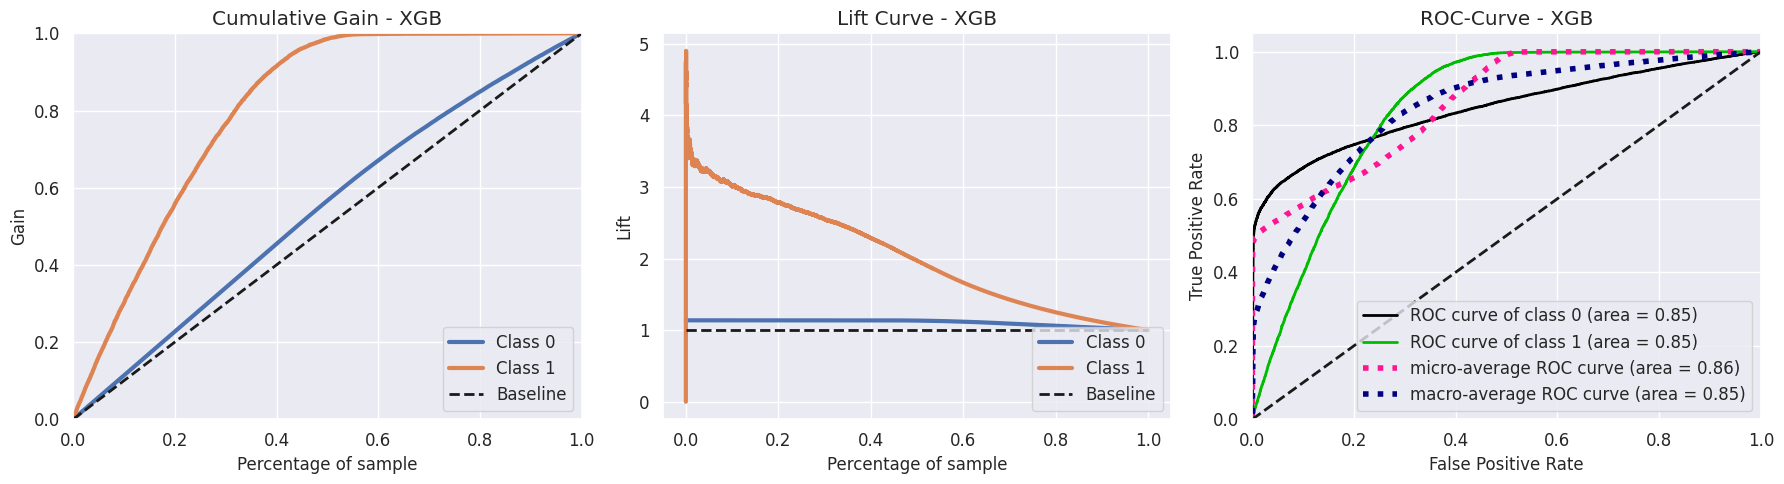

In [56]:
fig, axs = plt.subplots(ncols= 3, figsize = (18,5))

# cumulative gain - Metric for sorting problem
skplt.metrics.plot_cumulative_gain(y_validation, yhat_xgb, ax=axs[0],title='Cumulative Gain - XGB');

# Lift Curve
skplt.metrics.plot_lift_curve(y_validation, yhat_xgb,ax=axs[1],title='Lift Curve - XGB');

# Roc Curve
skplt.metrics.plot_roc(y_validation, yhat_xgb, ax=axs[2], title='ROC-Curve - XGB');

plt.tight_layout()

#### 7.1.2 - KNN

In [57]:
# model definition
knn_model = nh.KNeighborsClassifier( n_neighbors=8 )

# model training
knn_model.fit( x_train, y_training )

# model prediction - The generalization POWER
yhat_knn = knn_model.predict_proba( x_validation )

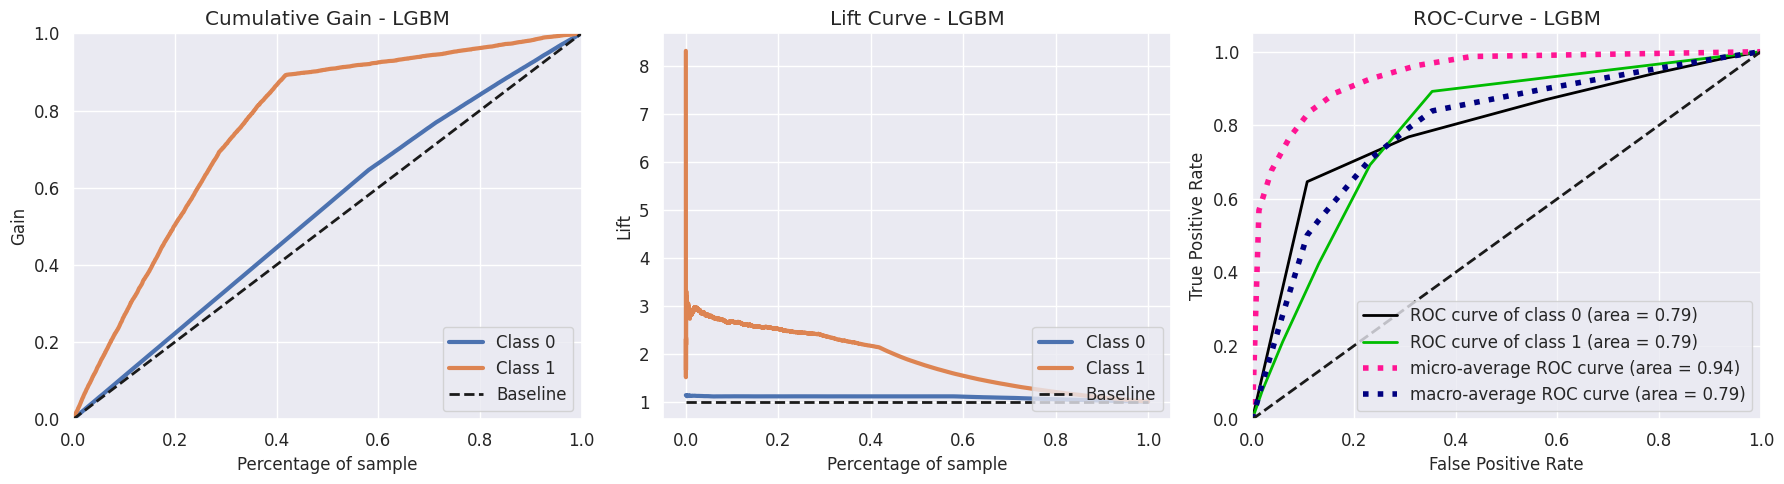

In [58]:
fig, axs = plt.subplots(ncols= 3, figsize = (18,5))

# cumulative gain - Metric for sorting problem
skplt.metrics.plot_cumulative_gain(y_validation, yhat_knn, ax=axs[0],title='Cumulative Gain - LGBM');

# Lift Curve
skplt.metrics.plot_lift_curve(y_validation, yhat_knn,ax=axs[1],title='Lift Curve - LGBM');

# Roc Curve
skplt.metrics.plot_roc(y_validation, yhat_knn, ax=axs[2], title='ROC-Curve - LGBM');

plt.tight_layout()

#### 7.1.3 - Light gradient Boostin Machine Classifier Model

In [59]:
# Model Definition
lgbm_model = lgbm.LGBMClassifier( learning_rate=0.09,max_depth=-5,random_state=42 )

# Model training
model_lgbm = lgbm_model.fit( x_train, y_training )

# Model Prediction
yhat_lgbm = model_lgbm.predict_proba( x_validation )

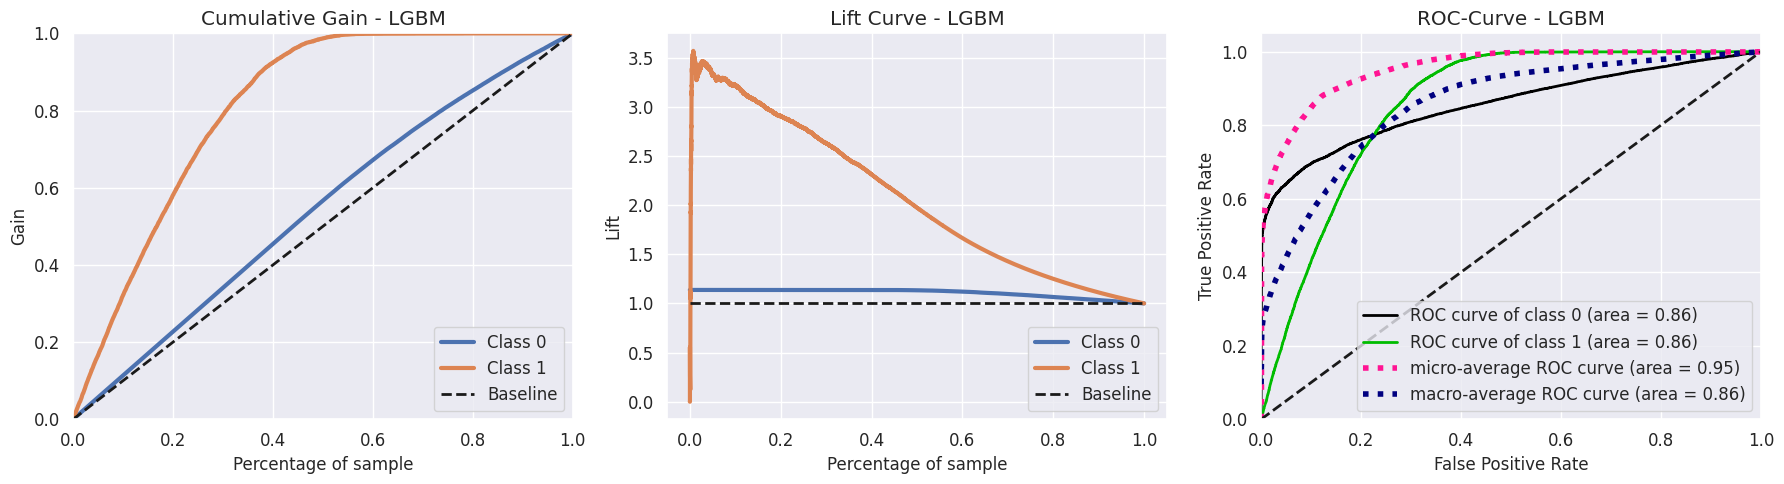

In [60]:
fig, axs = plt.subplots(ncols= 3, figsize = (18,5))

# cumulative gain - Metric for sorting problem
skplt.metrics.plot_cumulative_gain(y_validation, yhat_lgbm, ax=axs[0],title='Cumulative Gain - LGBM');

# Lift Curve
skplt.metrics.plot_lift_curve(y_validation, yhat_lgbm,ax=axs[1],title='Lift Curve - LGBM');

# Roc Curve
skplt.metrics.plot_roc(y_validation, yhat_lgbm, ax=axs[2], title='ROC-Curve - LGBM');

plt.tight_layout()

In [ ]:
# Model Definition
lgbm_model = lgbm.LGBMClassifier( learning_rate=0.09,max_depth=-5,random_state=42 )

# Model training
model_lgbm = lgbm_model.fit( x_training, y_training )

# Model Prediction
yhat_lgbm1 = model_lgbm.predict( x_validation )

## 8 - MODEL PERFORMANCE

### 8.1 - XGB MODEL PERFORMANCE

In [64]:
# Copy Data
df8_unbalanced = x_valid.copy()
df8_unbalanced['response'] = y_valid.copy()

# Propensity score
df8_unbalanced['score'] = yhat_xgb[:,1].tolist()

# sorted clients by score
df8_unbalanced = df8_unbalanced.sort_values( 'score', ascending=False )

# Compute precision at K
precision_atK = precision_at_k(df8_unbalanced, k=20000 )

# Compute precision at K
recall_atK = recall_at_k(df8_unbalanced, k=20000 )

xgb_performance = ml_performance('XGB Model', precision_atK, recall_atK )
xgb_performance

,Model Name,Precision_at_K,Recall_at_K
0,XGB Model,0.309635,0.750212


### 8.2 - KNN MODEL PERFORMANCE

In [65]:
# Copy Data
df8_unbalanced = x_valid.copy()
df8_unbalanced['response'] = y_valid.copy()

# Propensity score
df8_unbalanced['score'] = yhat_knn[:,1].tolist()

# sorted clients by score
df8_unbalanced = df8_unbalanced.sort_values( 'score', ascending=False )

# Compute precision at K
precision_atK = precision_at_k(df8_unbalanced, k=20000 )

# Compute precision at K
recall_atK = recall_at_k(df8_unbalanced, k=20000 )

KNN_performance = ml_performance('KNN_Model', precision_atK, recall_atK )
KNN_performance

,Model Name,Precision_at_K,Recall_at_K
0,KNN_Model,0.288586,0.699213


### 8.3 - LGBM MODEL PERFORMANCE

In [67]:
k = int(x_valid.shape[0]*0.4)

# Copy Data
df8_unbalanced = x_valid.copy()
df8_unbalanced['response'] = y_valid.copy()

# Propensity score
df8_unbalanced['score'] = yhat_lgbm[:,1].tolist()

# sorted clients by score
df8_unbalanced = df8_unbalanced.sort_values( 'score', ascending=False )

# Compute precision at K
precision_atK = precision_at_k(df8_unbalanced, k=k )

# Compute precision at K
recall_atK = recall_at_k(df8_unbalanced, k=k )

lgbm_performance = ml_performance('LGBM Model', precision_atK, recall_atK )
lgbm_performance

,Model Name,Precision_at_K,Recall_at_K
0,LGBM Model,0.27816,0.924652


In [ ]:
print(classification_report(y_valid,yhat_lgbm1))

### 8.3 - PERFORMANCE FOR ALL MODELS

In [ ]:
model_performance = pd.concat( [xgb_performance, KNN_performance, lgbm_performance] )
model_performance.sort_values('Precision_at_K', ascending= False)

## 9 - HYPERPARAMETER FINE TUNING

### 9.1 - Cross Validation

In [ ]:
# Concatenation train and validation dataset to use in cross-validation
df_cv = x_training.copy()
df_cv['response'] = y_training

df_aux = x_valid.copy()
df_aux['response'] = y_valid

df_cc = pd.concat([df_cv, df_aux])

In [ ]:
# Dictioary with models instantiated
models = { #'KNN': knn_model,
           'XGB Model': xgb_model}
           #'lgbm Model': lgbm_model}

# Cross-validated models performance
model_performance = pd.DataFrame()

for key in models.keys():
    performance_cv = cross_validation(5, key, models[key], df_cc, 14000)
    model_performance = pd.concat([model_performance, performance_cv], axis=1)

model_performance.T

### 9.3 - LGBM Fine Tunning

In [ ]:
X = df8.drop( 'response', axis=1 ).reset_index(drop=True)
y = df8[['response']].reset_index(drop=True)

In [ ]:
def objective(trial, X, y):
    param_grid = {
        #"device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.95, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.95, step=0.1
        ),
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1121218)

    cv_scores = np.empty(5)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model = lgbm.LGBMClassifier(objective="binary", **param_grid)
        model.fit( X_train, y_train, eval_set=[(X_test, y_test)], eval_metric="auc", early_stopping_rounds=100, callbacks=[LightGBMPruningCallback(trial, metric='auc')],  # Add a pruning callback 
                 )
        preds = model.predict_proba(X_test)
        cv_scores[idx] = log_loss(y_test, preds)

    return np.mean(cv_scores)

In [ ]:
study = optuna.create_study(direction='maximize' , study_name="LGBM Classifier")
func = lambda trial: objective(trial, X, y)
study.optimize(func, n_trials=20)

In [ ]:
print(f"\tBest value (rmse): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

#### 9.3.1 - LGBM After Fine Tuning

In [ ]:
params = {
'n_estimators': 10000,
'learning_rate': 0.023388717892026647,
'num_leaves': 2400,
'max_depth': 3,
'min_data_in_leaf': 8100,
'lambda_l1': 75,
'lambda_l2': 60,
'min_gain_to_split': 6.871322598066593,
'bagging_fraction': 0.6000000000000001,
'bagging_freq': 1,
'feature_fraction': 0.9}

In [ ]:
# Model Definition
lgbm_model = lgbm.LGBMClassifier(**params )

# Model Training
model_lgbm = lgbm_model.fit( x_training, y_training )

# Model Prediction
yhat_lgbm = model_lgbm.predict_proba( x_validation )

In [ ]:
# Model Definition
lgbm_model = lgbm.LGBMClassifier(n_estimators=10000, learning_rate=0.20184012746410188,is_unbalance=True, objective='binary', metric='auc', boost_from_average=False,
                                 num_leaves=20, max_depth=12, min_data_in_leaf=6500, lambda_l1=25, lambda_l2=90, min_gain_to_split=0.044158872935457116,
                                 bagging_fraction=0.9, bagging_freq=1, feature_fraction=0.9 )

# Model Training
model_lgbm = lgbm_model.fit( x_training, y_training )

# Model Prediction
yhat_lgbm = model_lgbm.predict_proba( x_validation )

In [ ]:
fig, axs = plt.subplots(ncols= 3, figsize = (18,5))

# cumulative gain - Metric for sorting problem
skplt.metrics.plot_cumulative_gain(y_validation, yhat_lgbm, ax=axs[0],title='Cumulative Gain - LGBM');

# Lift Curve
skplt.metrics.plot_lift_curve(y_validation, yhat_lgbm,ax=axs[1],title='Lift Curve - LGBM');

# Roc Curve
skplt.metrics.plot_roc(y_validation, yhat_lgbm, ax=axs[2], title='ROC-Curve - LGBM');

plt.tight_layout()

In [ ]:
# Copy Data
df8_unbalanced = x_valid.copy()
df8_unbalanced['response'] = y_valid.copy()

# Propensity score
df8_unbalanced['score'] = yhat_lgbm[:,1].tolist()

# sorted clients by score
df8_unbalanced = df8_unbalanced.sort_values( 'score', ascending=False )

# Compute precision at K
precision_atK = precision_at_k(df8_unbalanced, k=14000 )

# Compute precision at K
recall_atK = recall_at_k(df8_unbalanced, k=14000 )

lgbm_performance_cv = ml_performance('LGBM Model', precision_atK, recall_atK )
lgbm_performance_cv

In [ ]:
#pickle.dump(lgbm_model, open('C:/Users/perot/Documents/ds_repos/projects/Health_Insurance_Cross_Sell/src/models/lgbm_model.pkl', 'wb'))

### 9.4 - XGB FINE TUNING

In [ ]:
import random

In [ ]:
param = {
     'scale_pos_weight':[7.2,15,80],
     'n_estimators': [1000, 1500, 2000, 2500], 
     'eta': [0.01, 0.03],
     'max_depth': [3, 5, 9],
     'subsample': [0.1, 0.5, 0.7],
     'colsample_bytree': [0.3, 0.7, 0.9],
     'min_child_weight':[3, 8, 15] }

MAX_EVAL = 5

In [ ]:
final_result = pd.DataFrame()

for i in range( MAX_EVAL ):
# choose values for parameters randomly
    hp = { k: random.sample(v, 1)[0] for k, v in param.items() }
    print( hp )
    
#    # model
    model_xgb = XGBClassifier( scale_pos_weight= hp[ 'scale_pos_weight' ],
                               colsample_bytree =hp['colsample_bytree'],
                               subsample = hp['subsample'],
                               objective='binary:logistic', 
                               n_estimators=hp['n_estimators'], 
                               max_depth=hp['max_depth'],
                               min_child_weight = hp['min_child_weight'],
                               eta=hp['eta'])
    # performance
    result = cross_validation(2, 'xgb classifier', xgb_model, df_cc, 20000)
    final_result = pd.concat( [final_result, result] )

final_result

#### 9.4.1 - XGB AFTER TUNNING

In [ ]:
pickle.dump(model_xgb_cv, open('C:/Users/perot/Documents/ds_repos/projects/Health_Insurance_Cross_Sell/src/models/xgb_model_test.pkl', 'wb'))

In [ ]:
# XGB CROSS VALIDATION

# model definition
model_xgb_cv = XGBClassifier( scale_pos_weight = 7.2,
                              colsample_bytree = 0.9,
                              subsample = 0.1,
                              objective='binary:logistic', 
                              n_estimators=1000, 
                              max_depth=3,
                              min_child_weight = 8,
                              eta= 0.01 )

# model training
model_xgb_cv.fit( x_training, y_training )

# model prediction - The generalization POWER
yhat_xgb_cv = model_xgb_cv.predict_proba( x_validation )

In [ ]:
# Copy Data
df8_unbalanced = x_valid.copy()
df8_unbalanced['response'] = y_valid.copy()

# Propensity score
df8_unbalanced['score'] = yhat_xgb_cv[:,1].tolist()

# sorted clients by score
df8_unbalanced = df8_unbalanced.sort_values( 'score', ascending=False )

# Compute precision at K
precision_atK = precision_at_k(df8_unbalanced, k=14000 )

# Compute precision at K
recall_atK = recall_at_k(df8_unbalanced, k=14000 )

lgbm_performance_cv = ml_performance('XGB Model', precision_atK, recall_atK )
lgbm_performance_cv

## 10 - DEPLOYING MODEL TO PRODUCTION

### 10.1 - HEALTHINSURANCE CLASS

In [ ]:
import pickle
import inflection
import numpy  as np
import pandas as pd

class HealthInsurance:
    
    def __init__( self ):
        self.home_path                                = ''
        self.frequency_encode_policy_sales_scaler     = pickle.load( open( self.home_path + 'src/features/frequency_encode_policy_sales_scaler.pkl', 'rb') )
        self.frequency_encode_region_code_scaler      = pickle.load( open( self.home_path + 'src/features/frequency_encode_region_code_scaler.pkl', 'rb') )
        self.target_encode_gender_scaler              = pickle.load( open( self.home_path + 'src/features/target_encode_gender_scaler.pkl', 'rb') )
        self.target_encode_vintage_month_scaler       = pickle.load( open( self.home_path + 'src/features/target_encode_vintage_month_scaler.pkl', 'rb') )
        self.age_scaler                               = pickle.load( open( self.home_path + 'src/features/age_scaler.pkl', 'rb') )
        self.avg_vehicle_damage_region_code_scaler    = pickle.load( open( self.home_path + 'src/features/age_scaler.pkl', 'rb') )
        self.avg_vintage_age_scaler                   = pickle.load( open( self.home_path + 'src/features/avg_vintage_age_scaler.pkl', 'rb') )
        self.vintage_scaler                           = pickle.load( open( self.home_path + 'src/features/vintage_scaler.pkl', 'rb') )
        self.age_premium_scaler                       = pickle.load( open( self.home_path + 'src/features/age_premium_scaler.pkl', 'rb') )
        self.annual_premium_scaler                    = pickle.load( open( self.home_path + 'src/features/age_premium_scaler.pkl', 'rb') )
        self.avg_day_premium_policy_scaler            = pickle.load( open( self.home_path + 'src/features/avg_day_premium_policy_scaler.pkl', 'rb') )
        self.day_premium_scaler                       = pickle.load( open( self.home_path + 'src/features/day_premium_scaler.pkl', 'rb') )
        self.median_premium_by_region_scaler          = pickle.load( open( self.home_path + 'src/features/median_premium_by_region_scaler.pkl', 'rb') )
        self.region_premium_scaler                    = pickle.load( open( self.home_path + 'src/features/region_premium_scaler.pkl', 'rb') )
    
    def data_cleaning( self, df5 ):
 
        ## rename Columns
        cols_old = ['id', 'Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']

        snakecase = lambda x: inflection.underscore( x )
        cols_new = list( map( snakecase, cols_old ) )
        
        # rename
        df5.columns = cols_new
        
        return( df5 )

    def feature_engineering( self, df5 ):
        
        # Fitting vehicle_age column
        df5['vehicle_age'] = df5['vehicle_age'].apply(lambda x: 1 if (x == '< 1 Year') else 2 if (x == '1-2 Year') else 3)

        # Fitting vehicle_damage column
        df5['vehicle_damage'] = df5['vehicle_damage'].apply(lambda x: 1 if (x == 'Yes') else 0)
        
        # median_premium_by_region
        dict_region_code = df5[['annual_premium', 'region_code']].groupby('region_code').median().to_dict(orient='dict')['annual_premium']
        df5['median_premium_by_region'] = df5['region_code'].map(dict_region_code)

        # moda policy sales chanel por idade
        mode_policy_per_age = df5[['age', 'policy_sales_channel']].groupby('age').agg(pd.Series.mode).to_dict(orient='dict')['policy_sales_channel']
        df5['mode_policy_per_age'] = df5['age'].map(mode_policy_per_age)

        # Media de carros danificados por idade
        avg_carros_danificados_idade = df5[['age', 'vehicle_damage']].groupby('age').mean().to_dict(orient='dict')['vehicle_damage']
        df5['avg_vehicle_damage_per_age'] = df5['age'].map(avg_carros_danificados_idade)

        # Media de carros danificados por regiao
        avg_carros_danificados_regiao = df5[['age', 'region_code']].groupby('age').mean().to_dict(orient='dict')['region_code']
        df5['avg_vehicle_damage_region_code'] = df5['age'].map(avg_carros_danificados_regiao)

        # age_group feature creation
        df5['age_group'] = df5['age'].apply(lambda x: 1 if (x >= 18 | x < 30 ) else 2 if (x >= 30 | x < 60 ) else 3)

        # vintage_month feature cration
        df5['vintage_month'] = round(df5['vintage'] / 31)

        # day_premium feature creation
        df5['day_premium'] = df5['annual_premium']/df5['vintage']

        # age_premium feature cration
        df5['age_premium'] = df5['annual_premium']/df5['age']

        # Calculating Median Annual Premium by Region_code
        premium_rc = df5[['annual_premium', 'region_code']].groupby('region_code').median().to_dict(orient='dict')['annual_premium']
        df5['region_premium'] = df5['region_code'].map(premium_rc)

        # Calculating Median Aday_premium per policy_sales_channel
        day_premium_psc = df5[['day_premium', 'policy_sales_channel']].groupby('policy_sales_channel').mean().to_dict(orient='dict')['day_premium']
        df5['avg_day_premium_policy'] = df5['policy_sales_channel'].map(day_premium_psc)

        # avg vintage per age
        avg_vintage_per_age = df5[['age', 'vintage']].groupby('age').mean().to_dict(orient='dict')['vintage']
        df5['avg_vintage_age'] = df5['age'].map(avg_vintage_per_age)
        
        return( df5 )
    
    def data_preparation( self, df5 ):
              
        # STANDARDIZATION

        # annual premium
        df5['annual_premium'] = self.annual_premium_scaler.transform( df5[['annual_premium']].values )

        # age_premium
        df5['age_premium'] = self.age_premium_scaler.transform( df5[['age_premium']].values )

        # day_premium
        df5['day_premium'] = self.day_premium_scaler.transform( df5[['day_premium']].values )

        # avg_day_premium_policy
        df5['avg_day_premium_policy'] = self.avg_day_premium_policy_scaler.transform( df5[['avg_day_premium_policy']].values )

        # median_premium_by_region
        df5['median_premium_by_region'] = self.median_premium_by_region_scaler.transform( df5[['median_premium_by_region']].values )

        # region_premium
        df5['region_premium'] = self.region_premium_scaler.transform( df5[['region_premium']].values )



        # REESCALING

        # age
        df5['age'] = self.age_scaler.transform( df5[['age']].values )

        # vintage
        df5['vintage'] = self.vintage_scaler.transform( df5[['vintage']].values )

        # avg_vintage_age
        df5['avg_vintage_age'] = self.avg_vintage_age_scaler.transform( df5[['avg_vintage_age']].values )

        # vintage_month
        df5['vintage_month'] = self.vintage_scaler.transform( df5[['vintage_month']].values )

        # avg_vehicle_damage_region_code
        df5['avg_vehicle_damage_region_code'] = self.avg_vehicle_damage_region_code_scaler.transform( df5[['avg_vehicle_damage_region_code']].values )



        # ENCODER

        # policy sales channel
        df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( self.frequency_encode_policy_sales_scaler )

        # region code
        df5.loc[:, 'region_code'] = df5['region_code'].map( self.frequency_encode_region_code_scaler )

        # gender
        df5.loc[:, 'gender'] = df5['gender'].map( self.target_encode_gender_scaler )

        # vintage_month
        df5.loc[:, 'vintage_month'] = df5['vintage_month'].map( self.target_encode_vintage_month_scaler )

        # FILL NAN VALUES
        x_valid = x_valid.fillna(0)
        
        # Feature Selection
        cols_selected = ['vehicle_damage','previously_insured','vintage','day_premium','age_premium','annual_premium','vintage_month','region_code','avg_vehicle_damage_per_age','policy_sales_channel','age','median_premium_by_region','region_premium',
                         'avg_day_premium_policy','vehicle_age','avg_vehicle_damage_region_code','avg_vintage_age','gender']
        
        return df5[cols_selected]
    

    def get_prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict_proba( test_data )
        
        # join pred into the original data
        original_data['score'] = pred[:, 1].tolist()
        
        return original_data.to_json( orient='records', date_format='iso' )

### 10.2 - API HANDLER

In [ ]:
import pickle
import pandas as pd
import os
from flask                           import Flask, request, Response
from healthinsurance.healthinsurance import HealthInsurance

# logading model
model = pickle.load( open( 'src/models/xgb_model.pkl', 'rb' ) )
                          
# initialize API
app = Flask( __name__ )

@app.route( '/healthinsurance/predict', methods=['POST'] )
def health_insurance_predict():
    test_json = request.get_json()
    
    if test_json: #there is data
               
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
    
        else:
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() ) # multiple examples
            
        # Instantiate Rossmann Class
        pipeline = HealthInsurance()

        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
              
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )

        # Data Preparation
        df3 = pipeline.data_preparation( df2 )
                              
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
        
    else:
        return Response( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
    app.run('0.0.0.0')

#    port = os.environ.get('PORT', 5000)
#    app.run( host='0.0.0.0', port=port )